# Autoencoder in tensorflow
Feature learning and denoising autoencoder. This Net uses only fully connected layers.

In [ ]:
""" Literature:
http://yann.lecun.com/exdb/mnist/
"""

In [48]:
#%matplotlib notebook
%matplotlib inline
from __future__ import division, print_function, absolute_import
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import imageio
import math
from matplotlib import animation, rc
from IPython.display import HTML
import shutil
shutil.rmtree('images/')
os.mkdir('images')
#plt.ioff()

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [49]:
# Parameters
learning_rate = 0.0005
training_epochs = 200
batch_size = 100
display_step = 1
examples_to_show = 10
use_1norm = False  # 'euclidean'
adagrad = False

# Network Parameters
n_hidden_1 = 36 # 1st layer num features
n_hidden_2 = 16 # 2nd layer num features
n_connector = 2
n_input = 784 # MNIST data input (img shape: 28*282

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'connector_h1': tf.Variable(tf.random_normal([n_hidden_2, n_connector])),
    'decoder_h1': tf.Variable(tf.random_normal([n_connector, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'connector_b1': tf.Variable(tf.random_normal([n_connector])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
}

In [50]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']),name = 'enc_1')
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']),name = 'enc_2')
    print('Shape of encoder layers:\n {}\n {}'.format(layer_1, layer_2))
    return layer_2

def connector(x):
    # Connector layer with sigmod activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['connector_h1']),
                                   biases['connector_b1']),name = 'con_h1')
    
    print('Shape of connector layers:\n {}'.format(layer_1))
    return layer_1

# Building the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                               biases['decoder_b1']),name = 'dec_1')
    # Encoder Hidden layer with sigmoid activation #1
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']),name = 'dec_2')
    # Decoder Hidden layer with sigmoid activation #2
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']),name = 'dec_3')
    print('Shape of decoder layers:\n {}\n {} \n {}'.format(layer_1, layer_2, layer_3))
    return layer_3


# Construct model
encoder_op = encoder(X)
connector_op = connector(encoder_op)
decoder_op = decoder(connector_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
if not use_1norm:
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
else:
    cost = tf.norm(\
    (y_true - y_pred),
    ord=1,
    axis=None,
    keepdims=None,
    name=None,
    keep_dims=None)

'''Define optimizer:
RMSProp adjusts learning rate by an average of the recently
used gradients
http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
'''
if not adagrad:
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
else:
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

Shape of encoder layers:
 Tensor("enc_1_4:0", shape=(?, 36), dtype=float32)
 Tensor("enc_2_4:0", shape=(?, 16), dtype=float32)
Shape of connector layers:
 Tensor("con_h1_4:0", shape=(?, 2), dtype=float32)
Shape of decoder layers:
 Tensor("dec_1_4:0", shape=(?, 16), dtype=float32)
 Tensor("dec_2_4:0", shape=(?, 36), dtype=float32) 
 Tensor("dec_3_4:0", shape=(?, 784), dtype=float32)


In [51]:
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)

'''Just a helper function.
For animating the connector layer
'''
def save_plot():
    fig = plt.figure()
    plt.xlim(0,1)
    plt.ylim(0,1)
    conntor_output = sess.run(connector_op, feed_dict = {X:mnist.test.images})
    #arr = np.array(, b[:,0], b[:,1]))
    #len((np.argmax(mnist.test.labels, axis = 1)))
    L = np.array(list(zip(list(np.argmax(mnist.test.labels, axis = 1)),\
                          list(conntor_output[:,0]),\
                          list(conntor_output[:,1]))))
    df = pd.DataFrame(L, columns = ['Class','x1','x2'])
    imi = sns.lmplot(x='x1', y='x2', hue='Class', data=df, ci = None, fit_reg = False)
    plt.suptitle('Distribution of all images in the space spanned by the connector layer')
    plt.savefig('images/scatter_anim_'+str(epoch)+'.png')
    plt.close()



'''Training cycle.
Computing the graph in a cycle
'''
total_batch = int(mnist.train.num_examples/batch_size)
# Training cycle
first = True
second = True
third = True
ims = []
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c),
              "Current learning rate:{}".format(learning_rate))
        save_plot()
        plt.close()

        
    if epoch > training_epochs/4 and first == True:
        learning_rate *= 0.1
        first = False
    if epoch > 2*training_epochs/4 and second == True:
        learning_rate *= 0.1
        second = False
    if epoch > 3*training_epochs/4 and third == True:
        learning_rate *= 0.1
        third = False
    
print("Optimization Finished!")

Epoch: 0001 cost= 0.167784765 Current learning rate:0.0005
Epoch: 0002 cost= 0.102930963 Current learning rate:0.0005
Epoch: 0003 cost= 0.088626035 Current learning rate:0.0005
Epoch: 0004 cost= 0.079297401 Current learning rate:0.0005
Epoch: 0005 cost= 0.074761964 Current learning rate:0.0005
Epoch: 0006 cost= 0.071611412 Current learning rate:0.0005
Epoch: 0007 cost= 0.072815225 Current learning rate:0.0005
Epoch: 0008 cost= 0.066955097 Current learning rate:0.0005
Epoch: 0009 cost= 0.067852706 Current learning rate:0.0005
Epoch: 0010 cost= 0.068735562 Current learning rate:0.0005
Epoch: 0011 cost= 0.065647617 Current learning rate:0.0005
Epoch: 0012 cost= 0.062083203 Current learning rate:0.0005
Epoch: 0013 cost= 0.063203238 Current learning rate:0.0005
Epoch: 0014 cost= 0.063994236 Current learning rate:0.0005
Epoch: 0015 cost= 0.063729309 Current learning rate:0.0005
Epoch: 0016 cost= 0.063259035 Current learning rate:0.0005
Epoch: 0017 cost= 0.059531946 Current learning rate:0.00

## Test set evaluation and inspection of learned features / representations

C:\Users\Superman\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


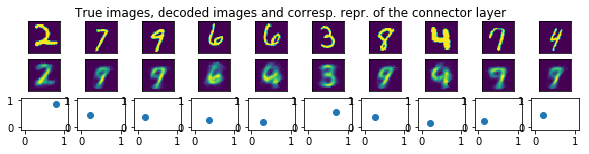

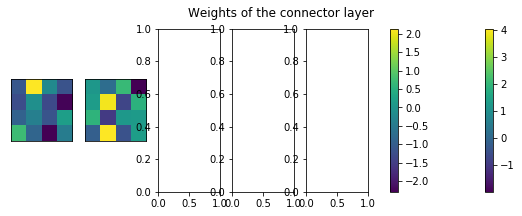

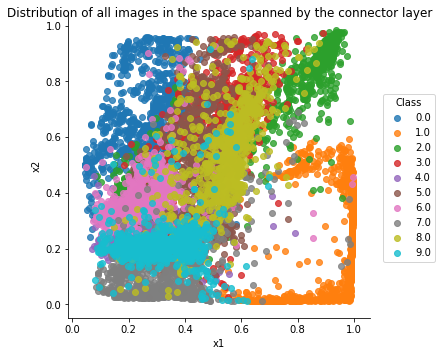

In [52]:
# Applying encode and decode over test set
# get example data of representations in the connecting layer
random_array = np.random.randint(len(mnist.test.images), size = (examples_to_show))# pick random img's
example_images = mnist.test.images[random_array]
y_pred_2 = sess.run(
    y_pred, feed_dict={X: mnist.test.images[random_array]})
representations = sess.run(connector_op, feed_dict = {X:example_images})

# Get weights
#indices = [i for i in range(examples_to_show)] # helper array for
W = sess.run(weights, feed_dict = {X:mnist.test.images})

# Compare original images with their reconstructions.
# Show representations in the last encoding layer
# show weights of the last encoding layer
f, a = plt.subplots(3, 10, figsize=(10, 2))

for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(example_images[i], (28, 28)))
    a[1][i].imshow(np.reshape(y_pred_2[i], (28, 28)))   
    represensations = np.reshape(representations[i], (1, 2))
    a[2][i].scatter(representations[i][1], representations[i][0])
    a[0][i].axes.get_xaxis().set_visible(False)
    a[0][i].axes.get_yaxis().set_visible(False)
    a[1][i].axes.get_xaxis().set_visible(False)
    a[1][i].axes.get_yaxis().set_visible(False)
    #a[2][i].axes.get_xaxis().set_visible(False)
    #a[2][i].axes.get_yaxis().set_visible(False)
    a[2][i].set_xlim(-0.1, 1.1)
    a[2][i].set_ylim(-0.1, 1.1)

plt.suptitle('True images, decoded images and corresp. repr. of the connector layer')
f.show()
plt.draw()


f, a = plt.subplots(1, 5, figsize=(10, 3))
for j in range(n_connector):
    plt.suptitle('Weights of the connector layer')
    im = a[j].imshow(np.reshape(W['connector_h1'][:,j], (4, 4)))
    a[j].axes.get_yaxis().set_visible(False)
    a[j].axes.get_xaxis().set_visible(False)
    f.colorbar(im, ax=a.ravel().tolist())

plt.draw()                  
f.show()


def show_distribution():
    #Distribution of images in the (a) connector (sub-)space.
    
    conntor_output = sess.run(connector_op, feed_dict = {X:mnist.test.images})
    #arr = np.array(, b[:,0], b[:,1]))
    #len((np.argmax(mnist.test.labels, axis = 1)))
    L = np.array(list(zip(list(np.argmax(mnist.test.labels, axis = 1)),\
                          list(conntor_output[:,0]),\
                          list(conntor_output[:,1]))))
    df = pd.DataFrame(L, columns = ['Class','x1','x2'])
    imi = sns.lmplot(x='x1', y='x2', hue='Class', data=df, ci = None, fit_reg = False)
    plt.suptitle('Distribution of all images in the space spanned by the connector layer')
    f.show()
    plt.draw()



show_distribution()


# Animation of the image representations
Development in the connector layer during training

In [61]:
import imageio
import os
os.remove('anim_.gif')

images = []
for i in range(999):
    try:
        fname = 'images/scatter_anim_{}.png'.format(i)
        images.append(imageio.imread(fname))
    except:
        pass
output_file = 'anim_.gif' 
imageio.mimsave(output_file, images)

<img src="anim_.gif">